In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Sentiment Classification

### Dataset
- Dataset of 50,000 movie reviews from IMDB, labeled by sentiment positive (1) or negative (0)
- Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers).
- For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".
- As a convention, "0" does not stand for a specific word, but instead is used to encode any unknown word.

Command to import data
- `from tensorflow.keras.datasets import imdb`

### Importing the data

In [2]:
#### Add your code here ####
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, GlobalMaxPool1D, LSTM, TimeDistributed, Flatten
from matplotlib import pyplot
from tensorflow.keras.datasets import imdb

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000, maxlen=300)

In [3]:
print(X_train.shape)
print(X_test.shape)
print(y_train)
print(y_test)

(19051,)
(19450,)
[1 0 0 ... 0 1 0]
[0 1 0 ... 0 0 0]


In [4]:
# Summarize number of Labels
print("Labels: ")
print(np.unique(y_train))

Labels: 
[0 1]


In [5]:
X_train_max_len = max(len(x) for x in X_train)
print("Max length of sequence in X_train: {}".format(X_train_max_len))

X_test_max_len = max(len(x) for x in X_test)
print("Max length of sequence in X_test:  {}".format(X_test_max_len))

Max length of sequence in X_train: 299
Max length of sequence in X_test:  299


### Padding each sentence to be of same length

Review length: 
Mean 159.68 words (60.730229)


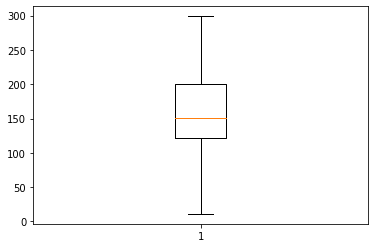

In [6]:
# Summarize review length
print("Review length: ")
result = [len(x) for x in X_train]
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))
# plot review length
pyplot.boxplot(result)
pyplot.show()

# we can see that max reviews are under the 500 characters mark

In [7]:
#padding to 300 length
X_train_padded = sequence.pad_sequences(X_train, maxlen=300)
X_test_padded = sequence.pad_sequences(X_test, maxlen=300)

### Print shape of features & labels

Number of review, number of words in each review

In [8]:

# summarize size
# number of reviews
print("Number of reviews in x_train: {}".format(len(X_train)))
print("Number of reviews in x_test: {}".format(len(X_test)))
#print("Padded Training and Test data: ")
#print(len(X_train.shape))
#print(len(X_test.shape))

Number of reviews in x_train: 19051
Number of reviews in x_test: 19450


In [9]:

# number of words in each review
print("Number of words in each review is {0}".format(X_train_padded[0].shape[0]))

Number of words in each review is 300


Number of labels

In [10]:

y_train.shape

(19051,)

In [23]:

y_test.shape
print("Unique Labels: ")
print(np.unique(y_train))

Unique Labels: 
[0 1]


### Print value of any one feature and it's label

Feature value

In [24]:

print("Value of the 100th review:" ,X_train[100])

Value of the 100th review: [1, 14, 9, 6, 389, 20, 19, 6, 253, 1096, 65, 5, 4, 6891, 7, 1181, 3855, 5, 4, 620, 756, 7, 803, 674, 11, 113, 97, 14, 6, 55, 467, 2525, 20, 92, 387, 4, 2, 7, 4, 182, 2, 25, 39, 319, 14, 2065, 47, 389, 388, 5, 13, 594, 33, 4, 192, 15, 212, 9, 115, 2525, 88, 156, 40, 2065, 97, 170, 39, 486, 8, 622, 1801, 168, 6529, 776, 87, 20, 32, 187]


Label value

In [25]:

print("Sentiment Label:", y_train[100])

Sentiment Label: 1


### Decoding the feature value to get original sentence

First, retrieve a dictionary that contains mapping of words to their index in the IMDB dataset

In [14]:

imdb_wordindex = imdb.get_word_index()

Now use the dictionary to get the original words from the encodings, for a particular sentence

In [15]:

index_from = 3
imdb_wordindex = {key:value + index_from for key, value in imdb_wordindex.items()}
imdb_wordindex['the']

4

In [16]:
inverted_word = {value: key for key, value in imdb_wordindex.items()}
[inverted_word[index] for index in X_train[100] if index > index_from]

['this',
 'is',
 'a',
 'wonderful',
 'movie',
 'with',
 'a',
 'fun',
 'clever',
 'story',
 'and',
 'the',
 'dynamics',
 'of',
 'culture',
 'differences',
 'and',
 'the',
 'running',
 'theme',
 'of',
 "what's",
 'important',
 'in',
 'life',
 'make',
 'this',
 'a',
 'very',
 'under',
 'appreciated',
 'movie',
 "don't",
 'let',
 'the',
 'of',
 'the',
 'world',
 'you',
 'from',
 'seeing',
 'this',
 'keaton',
 'has',
 'wonderful',
 'moments',
 'and',
 'i',
 'wonder',
 'at',
 'the',
 'fact',
 'that',
 'comedy',
 'is',
 'never',
 'appreciated',
 'because',
 'actors',
 'like',
 'keaton',
 'make',
 'going',
 'from',
 'humor',
 'to',
 'serious',
 'bits',
 'look',
 'tremendously',
 'easy',
 'great',
 'movie',
 'all',
 'around']

Get the sentiment for the above sentence
- positive (1)
- negative (0)

In [17]:

y_train[100]
# confirmed that the review is bad and the label also confirmed the same

1

### Define model
- Defining a Sequential Model

In [26]:


vocabulary = 10000
max_words = 300

model = Sequential()
model.add(Embedding(vocabulary, 100, input_length=max_words))
model.add(LSTM(100,return_sequences= True))
dense_layer = Dense(100, activation='relu')
model.add(TimeDistributed(dense_layer))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

### Compile the model

In [27]:

model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

### Print model summary

In [28]:

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 300, 100)          80400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 300, 100)          10100     
_________________________________________________________________
flatten_1 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 30001     
Total params: 1,120,501
Trainable params: 1,120,501
Non-trainable params: 0
_________________________________________________________________
None


### Fit the model

In [31]:

model.fit(X_train_padded, y_train, epochs=5, batch_size=64)

Epoch 1/5
298/298 [==============================] - 8s 28ms/step - loss: 0.1743 - accuracy: 0.9344
Epoch 2/5
298/298 [==============================] - 8s 28ms/step - loss: 0.0992 - accuracy: 0.9637
Epoch 3/5
298/298 [==============================] - 8s 28ms/step - loss: 0.0602 - accuracy: 0.9794
Epoch 4/5
298/298 [==============================] - 8s 28ms/step - loss: 0.0367 - accuracy: 0.9863
Epoch 5/5
298/298 [==============================] - 8s 28ms/step - loss: 0.0295 - accuracy: 0.9902


### Evaluating model

In [33]:

scores, accuracy = model.evaluate(X_test_padded, y_test, verbose=0)
print("Score: {:.4f}".format(scores))
print("Accuracy: {:.4f}".format(accuracy))

Score: 0.7076
Accuracy: 0.8644


### Predict on one sample

In [34]:
#### Add your code here ####
goodsample = "i liked the movie"
badsample = "i did not like this movie"

In [39]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
for review in [goodsample, badsample]:
    encoded_review = []
    review_split = review.split(" ")
    for word in review_split:
        encoded_review.append(imdb_wordindex[word])
    review_padded = pad_sequences([encoded_review], maxlen=300)
    pred = model.predict(review_padded)
    if pred > 0.5:
        sentiment = 'positive'
    else:
        sentiment = 'negative'
    print("Review: {0}\n\tSentiment: {1}".format(review, sentiment))

Review: i liked the movie
	Sentiment: positive
Review: i did not like this movie
	Sentiment: negative
